In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
sys.path.append('../') 

import warnings
from sklearn.exceptions import ConvergenceWarning

In [6]:
#cpath = '/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap/dataexp/pySuStaIn/dat/'
cpath = "/Users/linlin/Desktop/brain stuff/data/"  
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]  
 
#lftp = pd.read_csv(cpath+'lftp.csv')
df = pd.read_csv(cpath+'wide_mean_suvr_mtl.csv') 
df = df[df.visit==1]
zdf = pd.read_csv(cpath+'full_gmm2z_mtl.csv')
zdf = zdf[zdf.visit==1]
zdata = zdf.loc[:,lobes].values
dat = df.loc[:,lobes].values 
cn_idx = df.index[df['dx'] == 'CN']
eoad_idx = df.index[df['dx'] == 'EOAD'] 
eononad_idx = df.index[df['dx'] == 'EOnonAD']
df.head(2)


,subj,dx,ftp_date,L_MTL,L_frontal,L_occipital,L_parietal,L_temporal,R_MTL,R_frontal,R_occipital,R_parietal,R_temporal,visit
0,LDS0070120,CN,2019-06-20,1.182346,1.042777,1.108455,1.078236,1.133259,1.186170,1.03524,1.113742,1.085099,1.149995,1
1,LDS0070166,EOAD,2019-08-21,2.076745,2.520749,3.096130,3.158491,3.005546,1.876031,2.25349,2.846904,3.013359,2.766408,1


In [302]:
# read bootstrapped standardized data, and cn standardized data:
gmm2nonz = pd.read_csv(cpath+'gmm2nonz.csv')
gmm2z = pd.read_csv(cpath+'gmm2z.csv')
gmm3nonz = pd.read_csv(cpath+'gmm3nonz.csv')

In [8]:
len(df)

563

In [288]:
bstat = pd.read_csv(cpath+'bootstrapstat.csv')

# standardization stat

In [289]:
# Pivot bstat to get method_stat combinations
bstat = bstat[~bstat.method.isin(['cn'])]
bstat = bstat[~bstat.stat.isin(['slope','intercept'])]
bstat['method_stat'] = bstat['method'] + '_' + bstat['stat']
pivot_bstat = bstat.pivot(index='roi', columns='method_stat', values='value')

# Calculate mean and standard deviation for each group in lftp
grouped_lftp = lftp.groupby(['lobe','dx']).agg(suvr_mean=('mean_suvr', 'mean'), suvr_sd=('mean_suvr', 'std')).reset_index()

# Merge the two dataframes on the ROI column
merged = pd.merge(grouped_lftp, pivot_bstat, left_on='lobe', right_on='roi')

# Dropping unnecessary columns and renaming for clarity
merged = merged[merged.dx == 'CN']
merged = merged.drop(columns=['dx'])
mergedstat = merged.rename(columns={'lobe': 'ROI'})
mergedstat

,ROI,suvr_mean,suvr_sd,gmm2_bic,gmm2_mean,gmm2_sd,gmm2non_bic,gmm2non_mean,gmm2non_sd,gmm3non_bic,gmm3non_mean,gmm3non_sd
0,L_MTL,1.138153,0.081610,234.152103,1.148991,0.096815,181.853467,1.152177,0.078471,233.250071,1.083473,0.064058
3,L_frontal,1.052254,0.055529,479.104066,1.061038,0.069130,504.839565,1.067296,0.057521,474.094453,1.044170,0.059097
6,L_occipital,1.105393,0.050233,623.410892,1.114249,0.060688,691.400909,1.141557,0.073546,591.999018,1.106950,0.054629
9,L_parietal,1.076035,0.060066,781.917298,1.076139,0.070938,792.541605,1.089596,0.067906,779.520152,1.052305,0.059072
12,L_temporal,1.127988,0.055863,686.158001,1.140174,0.068729,668.936815,1.138389,0.060289,686.924685,1.109792,0.052483
15,R_MTL,1.139229,0.084206,200.531127,1.147317,0.102115,160.868532,1.150195,0.080269,201.480673,1.109232,0.078198
18,R_frontal,1.056771,0.058081,416.299270,1.065413,0.068358,468.140960,1.079304,0.061119,411.498644,1.050528,0.063679
21,R_occipital,1.099908,0.051394,575.864903,1.109751,0.057632,663.716293,1.121462,0.054840,540.446205,1.105395,0.055668
24,R_parietal,1.074975,0.059856,770.652937,1.070704,0.064192,778.563195,1.083269,0.058363,769.582695,1.039847,0.051995
27,R_temporal,1.126217,0.056450,622.831564,1.135352,0.066887,646.088079,1.134504,0.060066,622.650653,1.113467,0.048891


# regional (move down below!)

## func: component + annotation visualization in ROI

In [ ]:
def annotated_roi_dist(df, gmm,roi, stat = 'density', separate=True, annotate=True, ax=None, colors=sns.color_palette('tab10'), 
                  rois=lobes, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
    data = df[rois].values
    dx = df.dx
    offset = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.01
    roi_data = data[:, rois.index(roi)] 
    roi_df = pd.DataFrame({'roi':roi_data,'dx':dx}) 
    #gmm component or cn/eoad stats?

    colors = sns.color_palette("husl", 8)
    description = 'for 1st/2nd components'
    # gmm fit
    gmm.fit(roi_data.reshape(-1, 1))
    # mean,sd, sorted by first component = smaller mean 
    sorted_idx = np.argsort(gmm.means_.flatten())
    means = np.sort(gmm.means_.flatten())
    stds = np.sqrt(gmm.covariances_.flatten())[sorted_idx]   
    # plot overall pdf
    x = np.linspace(roi_data.min(), roi_data.max(), 1000) 
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1))) 
    ax.plot(x, pdf, color='black', linestyle='-')  
    # plot component pdf
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis] 
    for i in range(pdf_individual.shape[1]):
        ax.plot(x, pdf_individual[:,i], '--',color='gray')
    # plot intersection line
    filter = (x < means[1]) & (x > means[0])
    difference = np.abs(pdf_individual[:, 0][filter]  - pdf_individual[:, 1][filter])#between the means of the 2 components
    intersection = x[filter][np.argmin(difference)]  
    ax.axvline(intersection, color='black', linestyle='-',label='intersection')
    ax.text(intersection+offset, ax.get_ylim()[1]*0.8, f'{intersection:.2f}', color='black', ha='left',fontsize=14)    
    

    #separately color cn/eoad?
    if separate:
        sns.histplot(roi_df, x='roi', hue='dx', alpha=0.3, stat=stat, multiple='stack', ax=ax,**kwargs)
    else:
        sns.histplot(roi_df, x='roi', color='gray', alpha=0.5, stat=stat, multiple='stack', ax=ax,**kwargs)
        
    for i in [1]:
        if annotate:
            ax.axvline(means[i], color='black', linestyle='-')
            #ax.axvspan(means[i] - stds[i], means[i] + stds[i], color=colors[i], alpha=0.3)
            ax.text(means[i] + offset, ax.get_ylim()[1] * 0.85 + 0.01*i, f'{means[i]:.2f}', color='black', ha='left',fontsize=14) #± {stds[i]:.2f} 
        ax.set_title(f'{roi}')#(μ±σ {description})
        ax.set_xlabel('z-scores')
        ax.set_ylabel('Density') 
    return ax


In [518]:
def add_levels(cuts,ax,colors=['red','green','blue'],linestyle='--',offset=0.5):
    for i in range(len(cuts)):
        ax.axvline(cuts[i], color=colors[i], linestyle=linestyle)
        #ax.text(cuts[i]+offset, ax.get_ylim()[1] * 0.9, cuts[i], color=colors[i], ha='center')


## example z-scoring + threshold

In [530]:
import matplotlib.lines as mlines

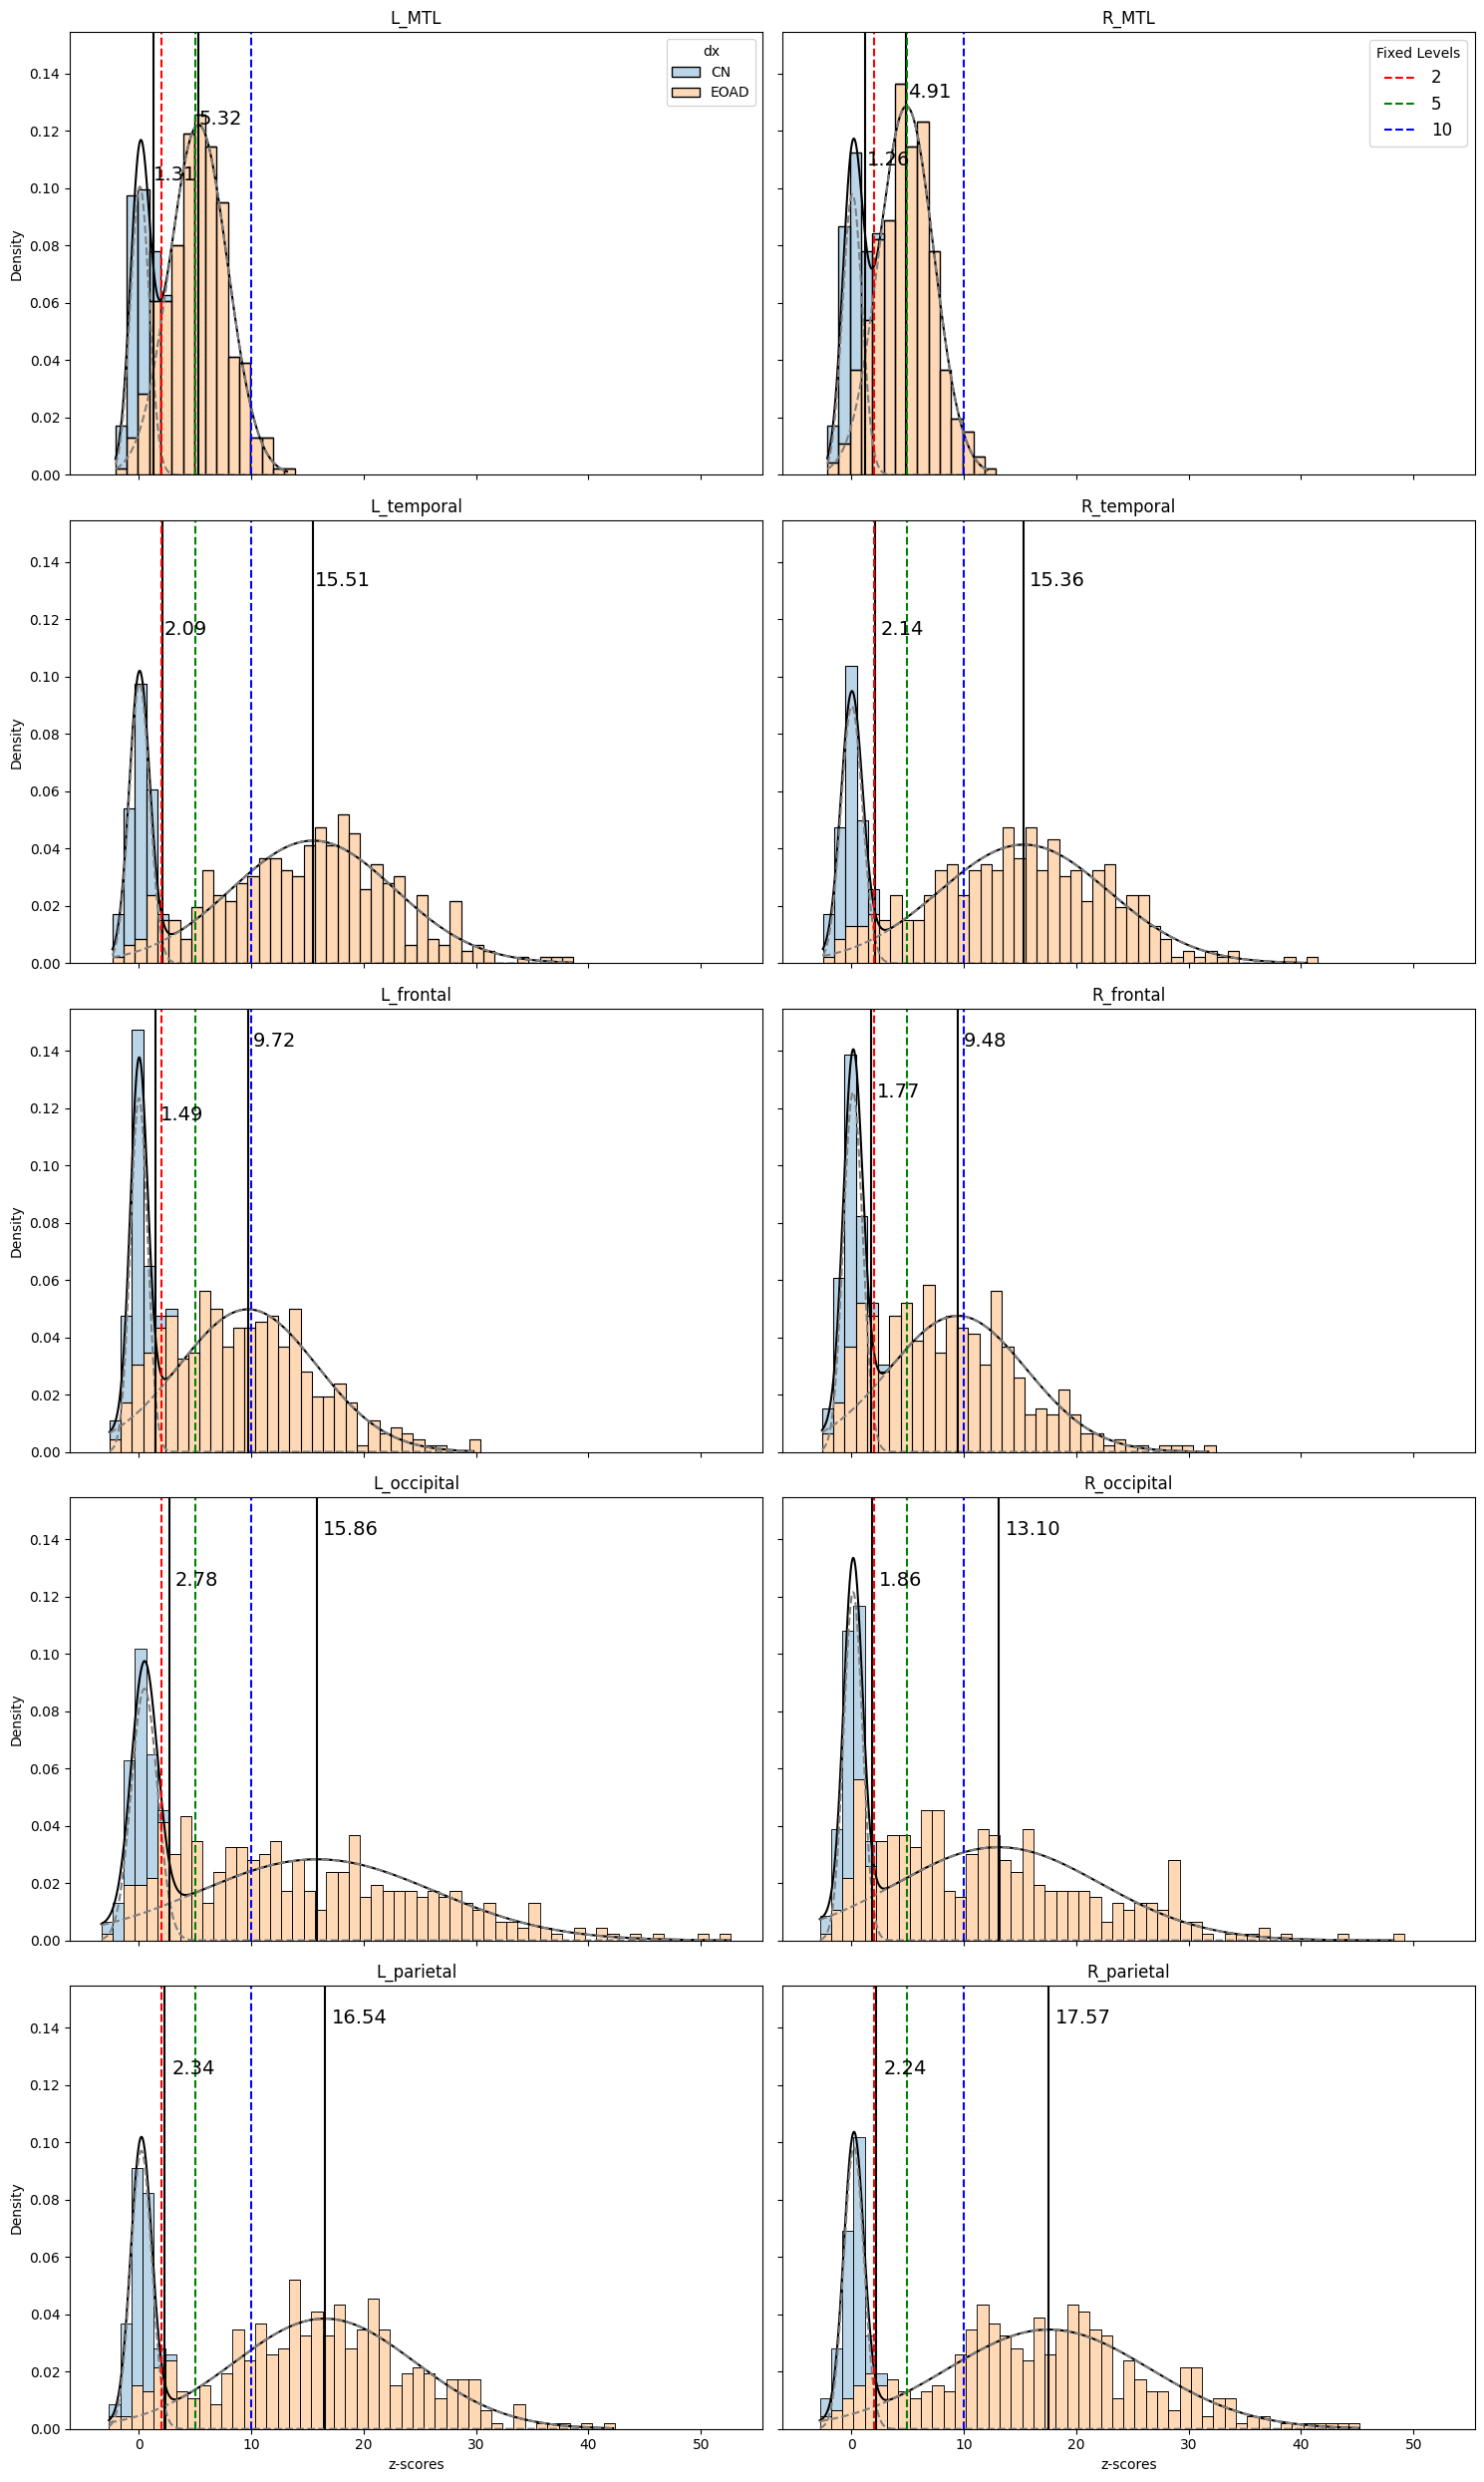

In [532]:
# Define the list of ROI pairs
roi_pairs = [('L_MTL', 'R_MTL'), ('L_temporal', 'R_temporal'), ('L_frontal', 'R_frontal'), 
             ('L_occipital', 'R_occipital'), ('L_parietal', 'R_parietal')]

# Create a 5x2 grid of subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharex=True, sharey=True)
sns.set_palette('tab10')

for i, (left_roi, right_roi) in enumerate(roi_pairs):
    # Subplot for the left ROI
    ax_left = axes[i, 0]
    annotated_roi_dist(df=gmm2z_wide[gmm2z_wide.dx.isin(['EOAD','CN'])], gmm=gmm, roi=left_roi, kde=False, ax=ax_left, stat='density', binwidth=1)
    add_levels([2, 5, 10], ax_left)
    if i == 0:
        ax_left.set_title(f'{left_roi}')
    else:
        ax_left.legend().set_visible(False)

    # Subplot for the right ROI
    ax_right = axes[i, 1]
    annotated_roi_dist(df=gmm2z_wide[gmm2z_wide.dx.isin(['EOAD','CN'])], gmm=gmm, roi=right_roi, kde=False, ax=ax_right, stat='density', binwidth=1)
    add_levels([2, 5, 10], ax_right)
    ax_right.set_title(f'{right_roi}')
    ax_right.legend().set_visible(False)  # Disable the legend for the right subplot
# Create custom legend for the first subplot
red_line = mlines.Line2D([], [], color='red', linestyle='--', label='2')
green_line = mlines.Line2D([], [], color='green', linestyle='--', label='5')
blue_line = mlines.Line2D([], [], color='blue', linestyle='--', label='10')

# Add the legend to the first subplot
axes[0, 1].legend(handles=[red_line, green_line, blue_line], title='Fixed Levels', loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


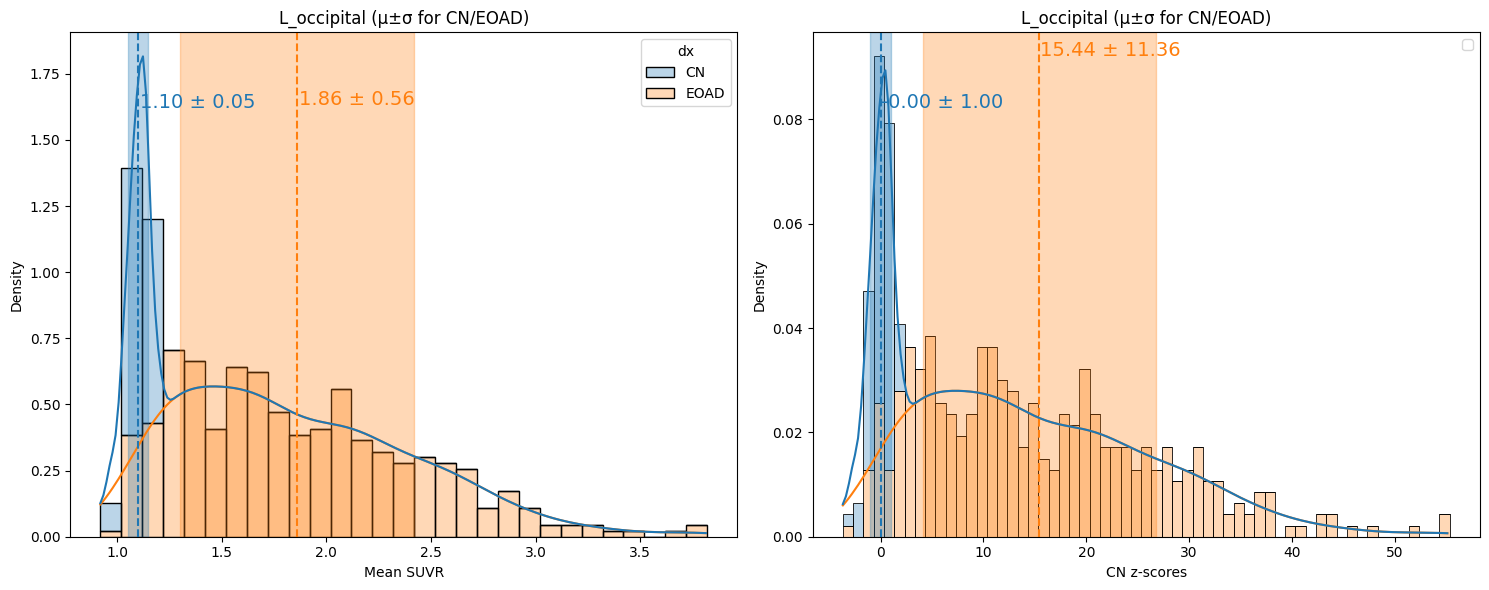

In [160]:
plt.figure(figsize=(15, 6))
sns.set_palette('tab10')
# Subplot for SUVR data
ax1 = plt.subplot(1, 2, 1)
annotated_roi_dist(data=dat, roi='L_occipital', dattype='Mean SUVR', kde=True, ax = ax1,stat='density',binwidth=0.1)

# Subplot for CN z-score data
ax2 = plt.subplot(1, 2, 2)#sharey=ax1) add this for same y axis. or sharex
annotated_roi_dist(data=zdata, roi='L_occipital', dattype='CN z-scores', kde=True, ax = ax2,stat='density',binwidth=1)
ax2.legend()#disable

plt.tight_layout()
plt.show() 


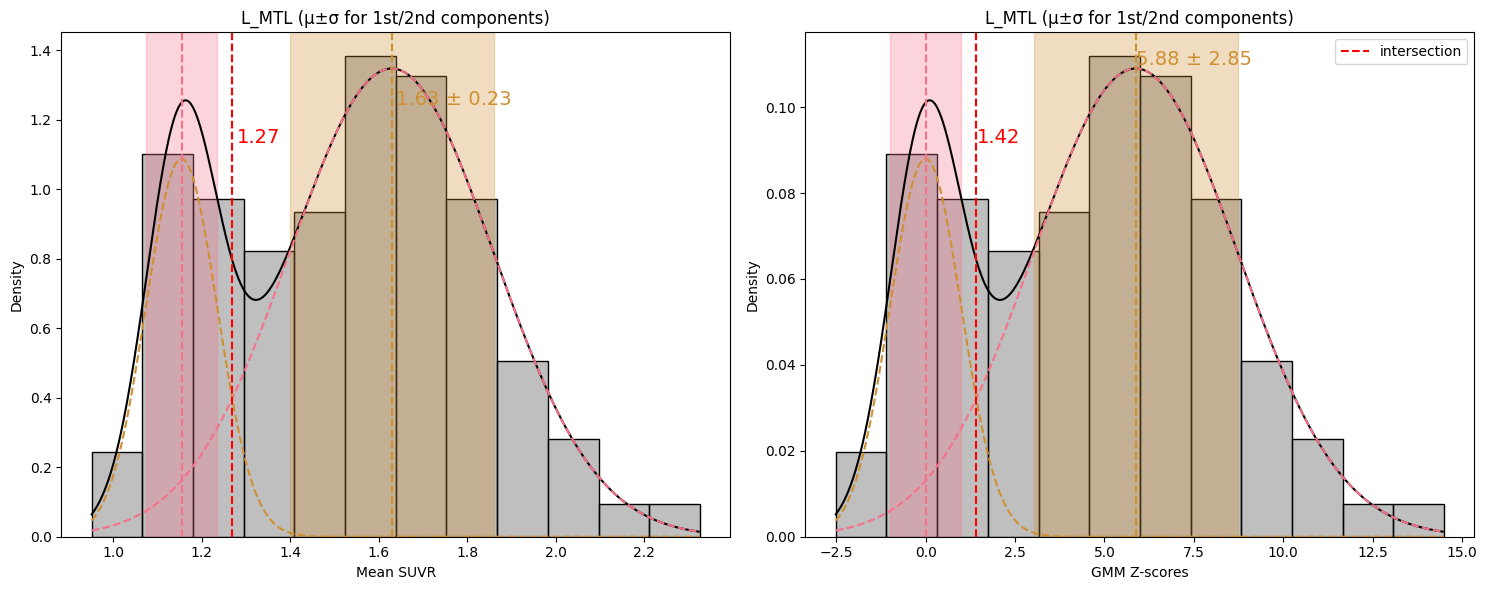

In [165]:
plt.figure(figsize=(15, 6))

# Subplot for SUVR data
ax1 = plt.subplot(1, 2, 1) 
annotated_roi_dist(data=dat, roi='L_MTL', dattype='Mean SUVR', gmmfit=True,separate=False,kde=False, ax = ax1)

# Subplot for CN z-score data
ax2 = plt.subplot(1, 2, 2)#sharey=ax1) add this for same y axis. or sharex
annotated_roi_dist(data=gmm_data,roi= 'L_MTL', dattype='GMM Z-scores',gmmfit=True,separate=False,kde=False, ax=ax2)
ax2.legend()

plt.tight_layout()
plt.show()


# Severity cutoffs

https://www.nature.com/articles/s41591-021-01309-6/figures/6  

https://www.youtube.com/watch?v=HbHhAYUGcP8&list=PL25fUWY3exLxYSPOnEe60kSEh0JRdVVPB&index=10 7:40 
 
uniform logic to decide individual severity levels  
 
 
note: dist between two dist.: Bhattacharyya, KL divergence


Supposedly

the first and the last level are the most tangible, i.e. the first is what sets apart the normal/abnormal, the last decides the 'end stage' of progression, beyond which the patients are deemed as having reached maximum severity. but for any (mid)points between these two levels the choice could be hard to justified.


- 1 level/2 stages = no and yes pathology
- 2 levels/3 stages = no, mild, severe
- 3 levels/4 stages = no mild, moderate, severe

ideally, the severity levels are proxies of progression rates

at?


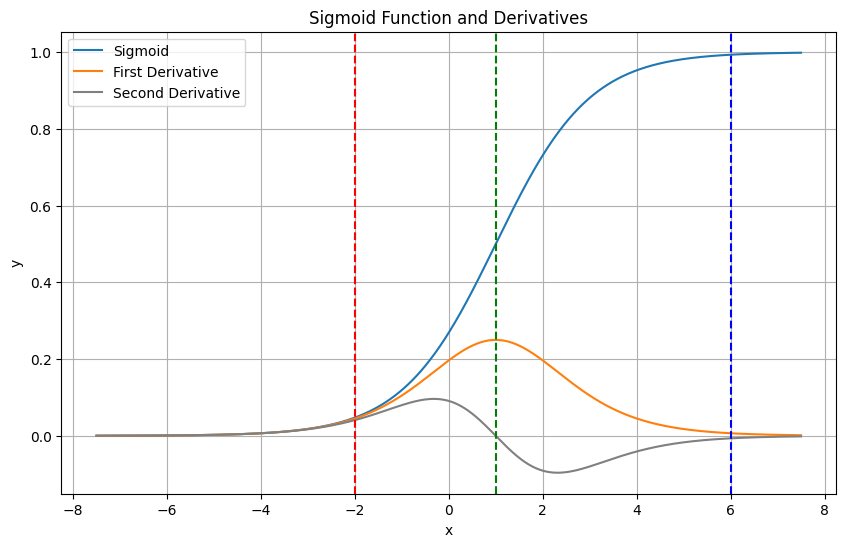

In [181]:
# hypothetical trajectory before tau levels start decreasing?
def sigmoid(x, a=1, b=1, c=1):
    return a / (1 + np.exp(-b * (x - c)))

def sigmoid_derivative(x, a=1, b=1, c=1):
    return a * b * np.exp(-b * (x - c)) / ((1 + np.exp(-b * (x - c))) ** 2)
 
def sigmoid_second_derivative(x, a=1, b=1, c=1):
    return a * b ** 2 * np.exp(-b * (x - c)) * (np.exp(-b * (x - c)) - 1) / ((1 + np.exp(-b * (x - c))) ** 3)

x = np.linspace(-7.5, 7.5, 1000)
plt.figure(figsize=(10, 6))
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.plot(x, sigmoid_derivative(x), label='First Derivative')
plt.plot(x, sigmoid_second_derivative(x), label='Second Derivative',color='gray')
plt.axvline(-2,color='red',linestyle='--') 
plt.axvline(1,color='green',linestyle='--') 
plt.axvline(6,color='blue',linestyle='--') 
plt.title('Sigmoid Function and Derivatives')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


## varied  

## func: calculate 2gmm-based cutoffs 
intersection, mean of the 2nd component, mean+-sd of the 2nd componet

In [533]:
def calculate_gmm_cutoffs(df, gmm, rois=lobes,EOnonAD=False):
    roi_list = []
    #mean1 is 0
    if not EOnonAD:
        df = df[df.dx!='EOnonAD']
    data = df[rois].values
    intersection_list = [] #intersection of component 1 and 2
    mean2_list = [] #component 2 mean
    sd2left_list = [] #component 2 mean - sd
    sd2right_list = [] #component 2 mean +sd 
    for _, roi_ex in enumerate(rois):
        roi_data = data[:, rois.index(roi_ex)] 
        gmm.fit(roi_data.reshape(-1, 1))   
        # get pdf and individual comaponent pdf from sample x
        x = np.linspace(np.min(roi_data), np.max(roi_data), 1000)
        pdf = np.exp(gmm.score_samples(x.reshape(-1, 1))) 
        weights = gmm.predict_proba(x.reshape(-1, 1))
        pdf_individual = weights * pdf[:, np.newaxis]  
        # mean and sd, sorted by mean ascending, so 1st (smaller mean) -> 2nd (larger mean) component
        sorted_idx = np.argsort(gmm.means_.flatten())
        means = np.sort(gmm.means_.flatten())
        stds = np.sqrt(gmm.covariances_.flatten())[sorted_idx]
        mean2_list.append(means[1] )
        sd2left_list.append(round(means[1] - stds[1], 2))
        sd2right_list.append(round(means[1] + stds[1], 2))
        # intersection 
        ## look at x between the two component means
        filter = (x < means[1]) & (x > means[0]) 
        ## calculate diff between individual pdf within that range
        difference = np.abs(pdf_individual[:, 0][filter]  - pdf_individual[:, 1][filter]) 
        ## find x where the diff is smallest in abs value. 
        intersection = x[filter][np.argmin(difference)]   
        intersection_list.append(intersection)
        roi_list.append(roi_ex) 

    return pd.DataFrame({
        'roi': roi_list, 
        'intersection': intersection_list,
        'c2mean-sd': sd2left_list,
        'c2mean': mean2_list,
        'c2mean+sd': sd2right_list
    })


In [403]:
gmm = GaussianMixture(n_components=2, init_params='random_from_data',random_state=42, covariance_type='full',n_init=100,tol=0)

sns.set_palette('tab10')
for i in list(range(0,10,2)):
    plt.figure(figsize=(15, 6))

    # Subplot for left
    ax1 = plt.subplot(1, 2, 1)
    annotated_roi_dist(data=dat,gmm=gmm, roi=lobes[i], dattype='mean SUVR', gmmfit=True, kde=False, ax = ax1,stat='density',binwidth=0.1)
    if i != 0:
        ax1.legend().set_visible(None)
    ax1.set_xlim([dat.min()-0.1,dat.max()+0.1]) #sharex for all if density
    ax1.set_ylim([0,2.5]) #sharey for all

    # Subplot for right
    ax2 = plt.subplot(1, 2, 2,sharex=ax1) #add this for same y axis. or sharex
    annotated_roi_dist(data=dat, gmm=gmm, roi=lobes[i+1], dattype='mean SUVR', gmmfit=True, kde=False, ax = ax2,stat='density',binwidth=0.1)
    ax2.legend().set_visible(None)
    ax2.set_xlim([dat.min()-0.1,dat.max()+0.1]) #sharex for all
    ax2.set_ylim([0,2.5]) #sharey for all

    plt.tight_layout()
    plt.show()



In [305]:
#to wide:
gmm2z = gmm2z.drop(columns=['Unnamed: 0'])
gmm2z_wide = gmm2z.pivot(index=['subj','dx'], columns='lobe', values='value').reset_index()[['subj','dx'] + lobes]
gmm2z_wide 

lobe,subj,dx,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal
0,LDS0070120,CN,0.732856,0.738673,0.005027,0.311309,-0.258979,-0.444753,0.108475,0.098508,0.105870,0.283103
1,LDS0070166,EOAD,7.543417,5.730201,27.955709,25.892019,20.186223,16.710129,36.391121,27.582178,29.197759,30.108455
2,LDS0070174,EOAD,1.883974,1.271264,18.740653,18.814639,9.942651,9.245584,19.465008,12.923950,20.963875,20.895289
3,LDS0070176,CN,-0.630208,-0.827316,-0.713735,-0.499379,-0.198924,-0.206714,-0.307235,-0.433037,0.207811,0.458061
4,LDS0070199,EOAD,3.999644,3.020953,11.823428,11.122044,7.725908,7.742617,10.353135,9.943339,12.668151,13.190164
...,...,...,...,...,...,...,...,...,...,...,...,...
576,LDS9410574,EOAD,3.854807,4.203316,23.888052,26.320307,8.840280,13.106291,21.769659,30.641138,15.925076,21.888055
577,LDS9410608,EOAD,8.702054,5.877296,19.048985,16.327730,4.111023,2.222904,23.075520,11.070858,13.343846,11.421694
578,LDS9410622,EOAD,4.084192,5.206212,1.067956,3.060161,-0.717395,-0.600731,-3.322282,-2.788662,-2.203711,-2.042158
579,LDS9410638,EOnonAD,0.937754,0.340946,0.534675,1.212270,0.596911,0.698344,0.000371,0.129343,0.114607,0.344579


In [534]:
method_name = "gmm2"
warnings.filterwarnings("ignore", category=ConvergenceWarning)
suvrcutoff = calculate_gmm_cutoffs(gmm2z_wide,gmm,EOnonAD=False)
suvrcutoff.to_csv(cpath+f'suvrcutoff_{method_name}.csv')


In [306]:
#to wide:
gmm2nonz = gmm2nonz.drop(columns=['Unnamed: 0'])
gmm2nonz_wide = gmm2nonz.pivot(index=['subj','dx'], columns='lobe', values='value').reset_index()[['subj','dx'] + lobes]
gmm2nonz_wide

lobe,subj,dx,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal
0,LDS0070120,CN,0.675690,0.816232,0.093484,0.423299,-0.285151,-0.533430,-0.033051,-0.047371,0.037557,0.312503
1,LDS0070166,EOAD,8.423720,6.619811,29.673618,24.358979,23.373843,16.856256,40.247905,29.808511,27.178436,28.477706
2,LDS0070174,EOAD,1.985259,1.435469,19.921349,17.736728,11.520078,9.289541,21.456551,13.885079,19.496747,19.777366
3,LDS0070176,CN,-0.874998,-1.004520,-0.667180,-0.335255,-0.215656,-0.292133,-0.494573,-0.624796,0.132662,0.477722
4,LDS0070199,EOAD,4.392149,3.469808,12.600867,10.538823,8.954884,7.766003,11.340560,10.647201,11.757365,12.501126
...,...,...,...,...,...,...,...,...,...,...,...,...
576,LDS9410574,EOAD,4.227376,4.844524,25.368828,24.759726,10.244426,13.203090,24.015172,33.131500,14.795869,20.714872
577,LDS9410608,EOAD,9.741843,6.790836,20.247656,15.409745,4.771774,2.170740,25.464938,11.872041,12.387745,10.831093
578,LDS9410622,EOAD,4.488336,6.010576,1.218379,2.995380,-0.815627,-0.691543,-3.841875,-3.183743,-2.117134,-1.883329
579,LDS9410638,EOnonAD,0.908792,0.353801,0.654009,1.266322,0.705276,0.625314,-0.153068,-0.013876,0.045709,0.370557


In [535]:
method_name = "gmm2non"
warnings.filterwarnings("ignore", category=ConvergenceWarning)
suvrcutoff = calculate_gmm_cutoffs(gmm2nonz_wide,gmm,EOnonAD=True)
suvrcutoff.to_csv(cpath+f'suvrcutoff_{method_name}.csv')


In [331]:
zdf = lftp.drop(columns=['Unnamed: 0'])
zdf = zdf.pivot(index=['subj','dx'], columns='lobe', values='mean_suvr').reset_index()[['subj','dx'] + lobes]
zdf

lobe,subj,dx,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal
0,LDS0070120,CN,1.211290,1.212625,1.133259,1.149995,1.042777,1.035240,1.108455,1.113742,1.078236,1.085099
1,LDS0070166,EOAD,1.876980,1.716513,3.005546,2.766408,2.520749,2.253490,3.096130,2.846904,3.158491,3.013359
2,LDS0070174,EOAD,1.323805,1.266389,2.388272,2.319197,1.780247,1.723397,2.168865,1.922534,2.569716,2.417712
3,LDS0070176,CN,1.078059,1.054540,1.085112,1.098769,1.047119,1.052144,1.085681,1.080222,1.085525,1.096410
4,LDS0070199,EOAD,1.530598,1.443018,1.924919,1.833112,1.620000,1.616664,1.669689,1.734572,1.976519,1.919562
...,...,...,...,...,...,...,...,...,...,...,...,...
576,LDS9410574,EOAD,1.516442,1.562376,2.733072,2.793471,1.700558,1.997564,2.295121,3.039807,2.209410,2.481896
577,LDS9410608,EOAD,1.990230,1.731362,2.408926,2.162053,1.358682,1.224683,2.366660,1.805675,2.024835,1.805228
578,LDS9410622,EOAD,1.538863,1.663617,1.204460,1.323692,1.009639,1.024163,0.920507,0.931673,0.913086,0.934767
579,LDS9410638,EOnonAD,1.231318,1.172475,1.168738,1.206926,1.104649,1.116416,1.102532,1.115687,1.078860,1.089073


In [536]:
method_name = "cn"
warnings.filterwarnings("ignore", category=ConvergenceWarning)
suvrcutoff = calculate_gmm_cutoffs(zdf,gmm,EOnonAD=False)
suvrcutoff.to_csv(cpath+f'suvrcutoff_{method_name}.csv')


### threshold df

In [537]:
suvrcutoff_2gmm = pd.read_csv(cpath + 'suvrcutoff_gmm2.csv')
suvrcutoff_2gmmnon = pd.read_csv(cpath + 'suvrcutoff_gmm2non.csv')
suvrcutoff_cn = pd.read_csv(cpath + 'suvrcutoff_cn.csv')

In [538]:
def assign_stage_varied(long_df, cutoff_df, method):
    # Merge long_df with cutoff_df on 'roi'
    merged_df = pd.merge(long_df, cutoff_df, left_on='lobe',right_on='roi')
    
    # Define function to determine stage
    def determine_stage(row):
        value = row['value']
        if value < row['intersection']:
            return 1
        elif value < row['c2mean']:
            return 2
        else:
            return 3
        #elif value < row['c2mean+sd']:
         #   return 3
        #else:
         #   return 4

    # Apply the function to determine the stage for each row
    merged_df['stage'] = merged_df.apply(determine_stage, axis=1)
    
    # Select relevant columns and add the method column
    result_df = merged_df[['subj', 'roi', 'stage']]
    result_df['method'] = method
    
    return result_df
def assign_stage_fixed(long_df,  method="fixed"):
    # Merge long_df with cutoff_df on 'roi' 
    
    # Define function to determine stage
    def determine_stage(row):
        value = row['value']
        if value < 2:
            return 1
        elif value < 5:
            return 2
        elif value < 10:
            return 3
        else:
            return 4

    # Apply the function to determine the stage for each row
    long_df['stage'] = long_df.apply(determine_stage, axis=1)
    
    # Select relevant columns and add the method column
    result_df = long_df[['subj', 'lobe', 'stage']].rename(columns={'lobe':'roi'})
    result_df['method'] = method
    
    return result_df 


In [539]:
zdf = pd.read_csv(cpath+'zdata.csv')
longz = pd.melt(zdf, id_vars=['subj', 'dx'], 
                  value_vars=['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal',
                              'L_occipital', 'R_occipital', 'L_parietal', 'R_parietal'],
                  var_name='lobe', value_name='value')

In [540]:

gmm2nonvaried = assign_stage_varied(gmm2nonz[gmm2nonz.dx == 'EOAD'], suvrcutoff_2gmmnon, 'gmm2non_varied')
gmm2varied = assign_stage_varied(gmm2z[gmm2z.dx == 'EOAD'], suvrcutoff_2gmm, 'gmm2_varied')

gmm2nonfixed = assign_stage_fixed(gmm2nonz[gmm2nonz.dx == 'EOAD'],method = 'gmm2non_fixed')
gmm2fixed = assign_stage_fixed(gmm2z[gmm2z.dx == 'EOAD'],method = 'gmm2_fixed')
cnfixed = assign_stage_fixed(longz[longz.dx == 'EOAD'],method = 'cn_fixed')
cnvaried = assign_stage_varied(longz[longz.dx == 'EOAD'], suvrcutoff_cn, 'cn_varied')

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_17934/4140459428.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['method'] = method
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_17934/4140459428.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['method'] = method
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_17934/4140459428.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [544]:
contigency_df = pd.concat([gmm2nonvaried,gmm2nonfixed,gmm2varied,gmm2fixed,cnvaried,cnfixed], ignore_index=True)
# Pivot table to count the number of subjects assigned to each stage for each ROI
pivot_table = pd.pivot_table(contigency_df, index=['roi', 'stage'], columns='method', aggfunc='size', fill_value=0)
# Reindex to ensure all stages are represented
stages = np.arange(1, 5)
pivot_table.reindex(pd.MultiIndex.from_product([pivot_table.index.levels[0], stages]), fill_value=0).to_clipboard() 

# E

### crosstab - grouped

In [429]:
def plot_confusion_matrices(contigency_df, rois, method1, method1_name, method2, method2_name):
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    #fig.suptitle('Stage Assignment for Different ROIs (only EOAD subjects)', fontsize=16)
    
    for idx, roi in enumerate(rois):
        ax = axes[idx // 5, idx % 5]
        
        # Filter data for the given ROI
        roi_df = contigency_df[contigency_df['roi'] == roi]
        
        # Create separate dataframes for each method
        method1_df = roi_df[roi_df['method'] == method1].set_index('subj')['stage']
        method2_df = roi_df[roi_df['method'] == method2].set_index('subj')['stage']
        
        # Merge the dataframes to align subjects
        merged_df = pd.merge(method1_df, method2_df, left_index=True, right_index=True, suffixes=(f'_{method1}', f'_{method2}'))
        
        # Create a confusion matrix
        confusion_matrix = pd.crosstab(merged_df[f'stage_{method1}'], merged_df[f'stage_{method2}'])
        
        # Ensure the confusion matrix is 4x4 with all stages 1-4
        confusion_matrix = confusion_matrix.reindex(index=[1, 2, 3], columns=[1, 2, 3], fill_value=0)
        
        # Calculate percentages
        total_counts = confusion_matrix.values.sum()
        percentages = confusion_matrix / total_counts * 100
        
        # Calculate overall agreement
        overall_agreement = np.trace(confusion_matrix) / total_counts * 100
        
        # Create a mask to hide annotations for zero values
        mask = confusion_matrix == 0
        
        # Plot confusion matrix
        sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12}, square=True, ax=ax, mask=mask)
        
        # Annotate percentages
        for i in range(len(confusion_matrix)):
            for j in range(len(confusion_matrix.columns)):
                count = confusion_matrix.iat[i, j]
                percentage = percentages.iat[i, j]
                if count > 0:  # Only annotate if count is greater than 0
                    text_color = 'white' if percentage >= 20 else 'black'
                    ax.text(j + 0.5, i + 0.7, f'{percentage:.2f}%', 
                            ha='center', va='center', color=text_color, fontsize=15, fontweight='bold')
        
        ax.set_title(roi, fontweight='bold', fontsize=15)
        ax.set_xlabel(f'Overall Agreement: {overall_agreement:.2f}%', fontweight='bold', fontsize=15)
        ax.set_ylabel('')
        ax.tick_params(axis='both', labelsize=15)
    # Set overall labels
    fig.text(0.5, , method2_name, ha='center', fontsize=16, fontweight='bold') # method 2, x, horizontal
    fig.text(0, 0.5, method1_name, va='center', rotation='vertical', fontsize=16, fontweight='bold') # Method: 2GMM w/o EOnonAD
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Example usage for 10 ROIs, comparing 'fixed' and 'gmm2non' methods
rois = ['L_MTL', 'L_frontal', 'L_occipital', 'L_parietal', 'L_temporal', 'R_MTL', 'R_frontal', 'R_occipital', 'R_parietal', 'R_temporal']


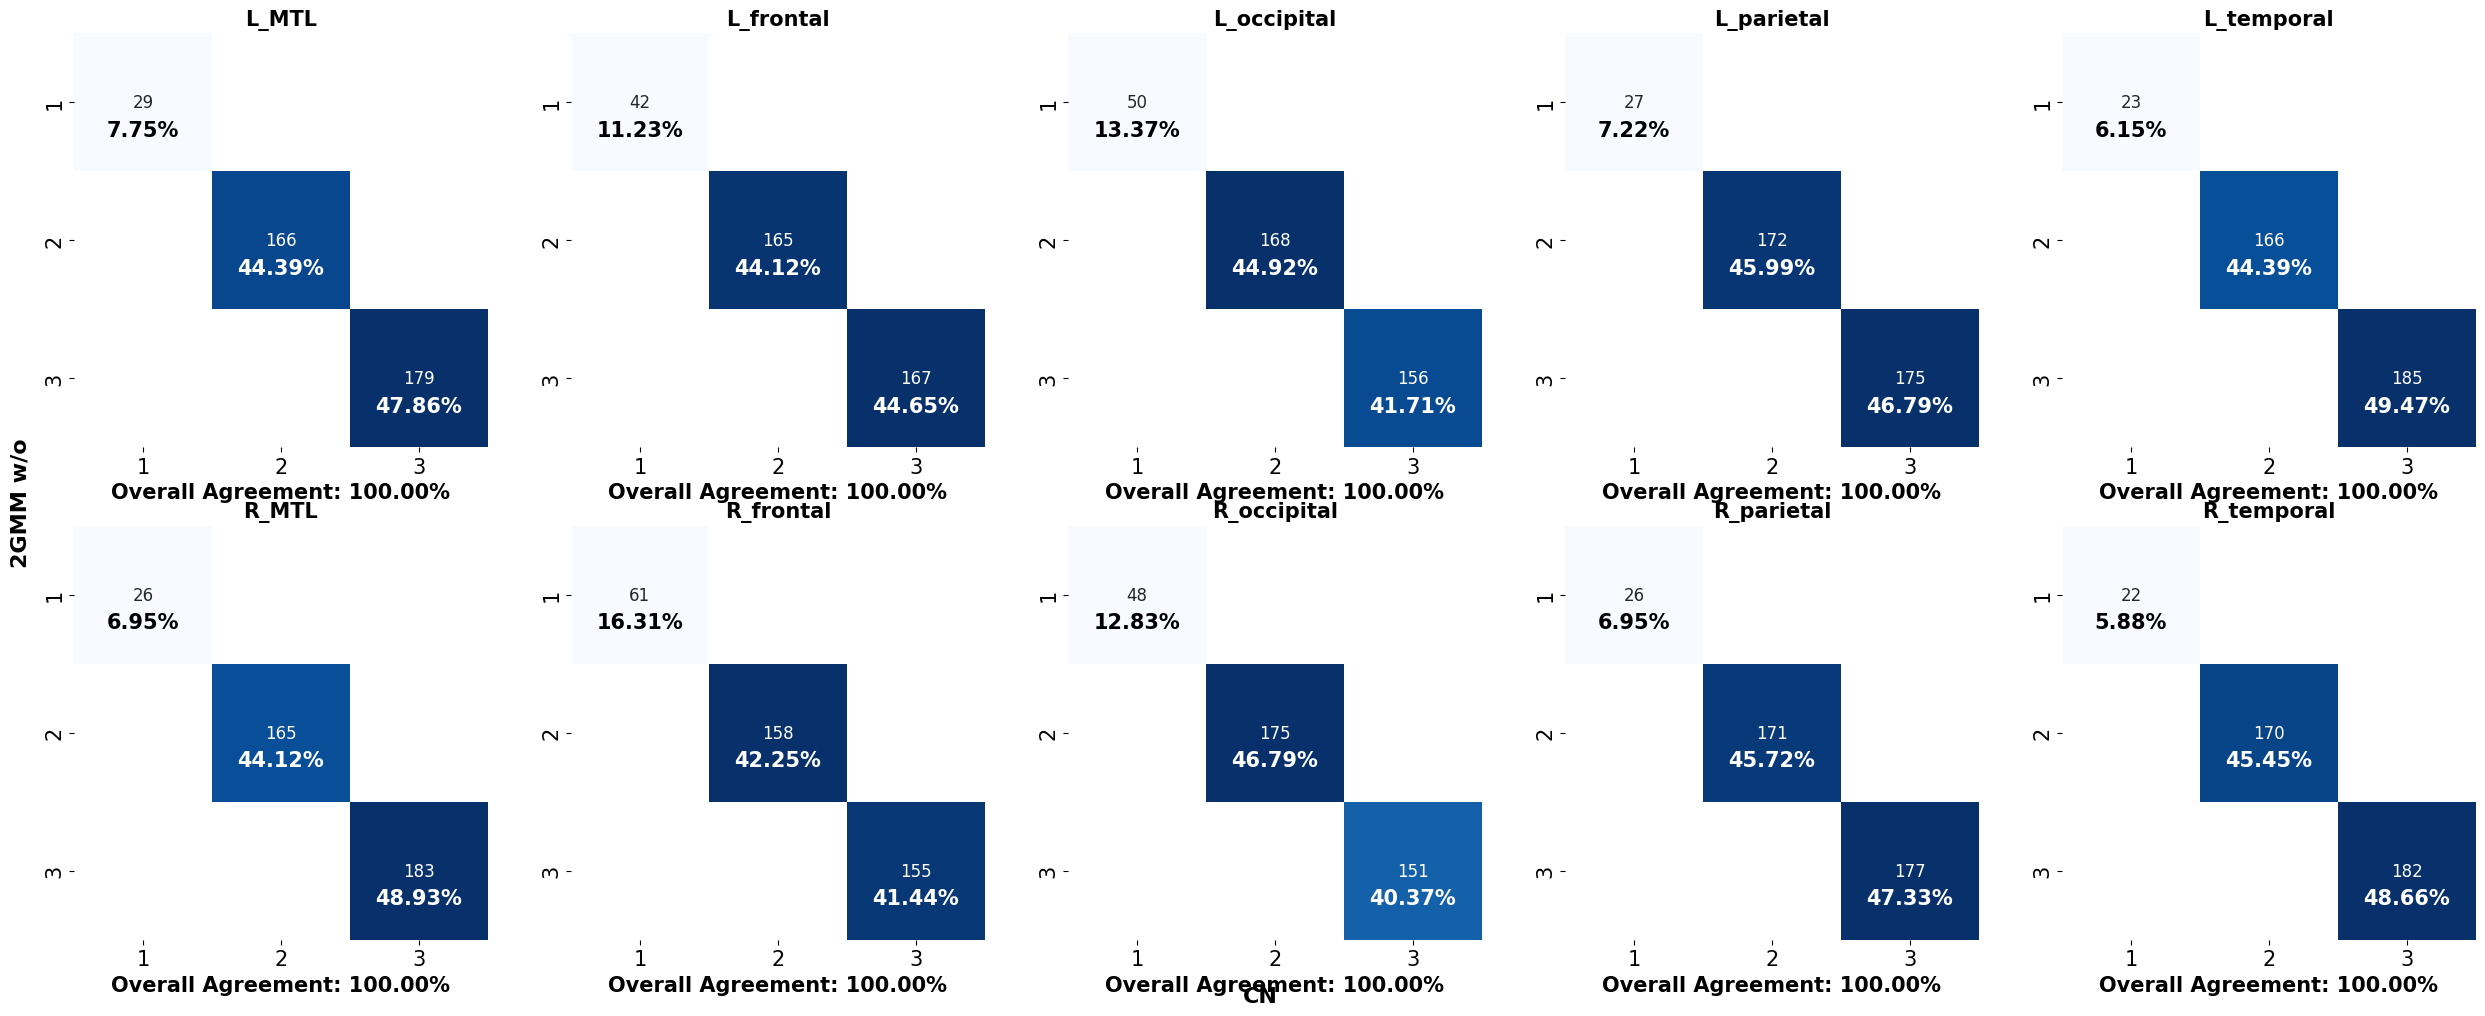

In [543]:
#(contigency_df, rois, method1,method1_name,method2, method2_name ):
plot_confusion_matrices(contigency_df, rois, 'gmm2_varied','2GMM w/o', 'cn_varied','CN') # y, x

In [436]:
pivot_df = contingency_df.pivot_table(index=['subj', 'roi'], columns='method', values='stage').reset_index()
pivot_df[(pivot_df['gmm2_varied'] == 2) & (pivot_df['cn_varied'] == 1)]

method,subj,roi,cn_fixed,cn_varied,gmm2_fixed,gmm2_varied,gmm2non_fixed,gmm2non_varied
3000,LDS3600030,L_MTL,1,1,1,2,1,1


In [442]:
lftp[lftp.subj=='LDS3600030']

,Unnamed: 0,subj,dx,lobe,mean_suvr
4710,4710,LDS3600030,EOAD,L_MTL,1.267830
4711,4711,LDS3600030,EOAD,L_frontal,1.759515
4712,4712,LDS3600030,EOAD,L_occipital,1.233256
4713,4713,LDS3600030,EOAD,L_parietal,2.108165
4714,4714,LDS3600030,EOAD,L_temporal,2.050071
4715,4715,LDS3600030,EOAD,R_MTL,1.418177
4716,4716,LDS3600030,EOAD,R_frontal,1.977344
4717,4717,LDS3600030,EOAD,R_occipital,1.427976
4718,4718,LDS3600030,EOAD,R_parietal,2.281636
4719,4719,LDS3600030,EOAD,R_temporal,2.239995


In [439]:
longz[longz.subj == 'LDS3600030']

,subj,dx,lobe,value
375,LDS3600030,EOAD,L_MTL,1.598102
837,LDS3600030,EOAD,R_MTL,3.331666
1299,LDS3600030,EOAD,L_temporal,16.600726
1761,LDS3600030,EOAD,R_temporal,19.843329
2223,LDS3600030,EOAD,L_frontal,12.809678
2685,LDS3600030,EOAD,R_frontal,15.940601
3147,LDS3600030,EOAD,L_occipital,2.559978
3609,LDS3600030,EOAD,R_occipital,6.419952
4071,LDS3600030,EOAD,L_parietal,17.281784
4533,LDS3600030,EOAD,R_parietal,20.274915


In [441]:
gmm2z[gmm2z.subj=='LDS3600030']

,subj,dx,lobe,value
471,LDS3600030,EOAD,L_MTL,1.311306
1052,LDS3600030,EOAD,L_frontal,9.655857
1633,LDS3600030,EOAD,L_occipital,2.386570
2214,LDS3600030,EOAD,L_parietal,14.509191
2795,LDS3600030,EOAD,L_temporal,13.691783
3376,LDS3600030,EOAD,R_MTL,2.774881
3957,LDS3600030,EOAD,R_frontal,12.821555
4538,LDS3600030,EOAD,R_occipital,5.081474
5119,LDS3600030,EOAD,R_parietal,18.790539
5700,LDS3600030,EOAD,R_temporal,17.561212


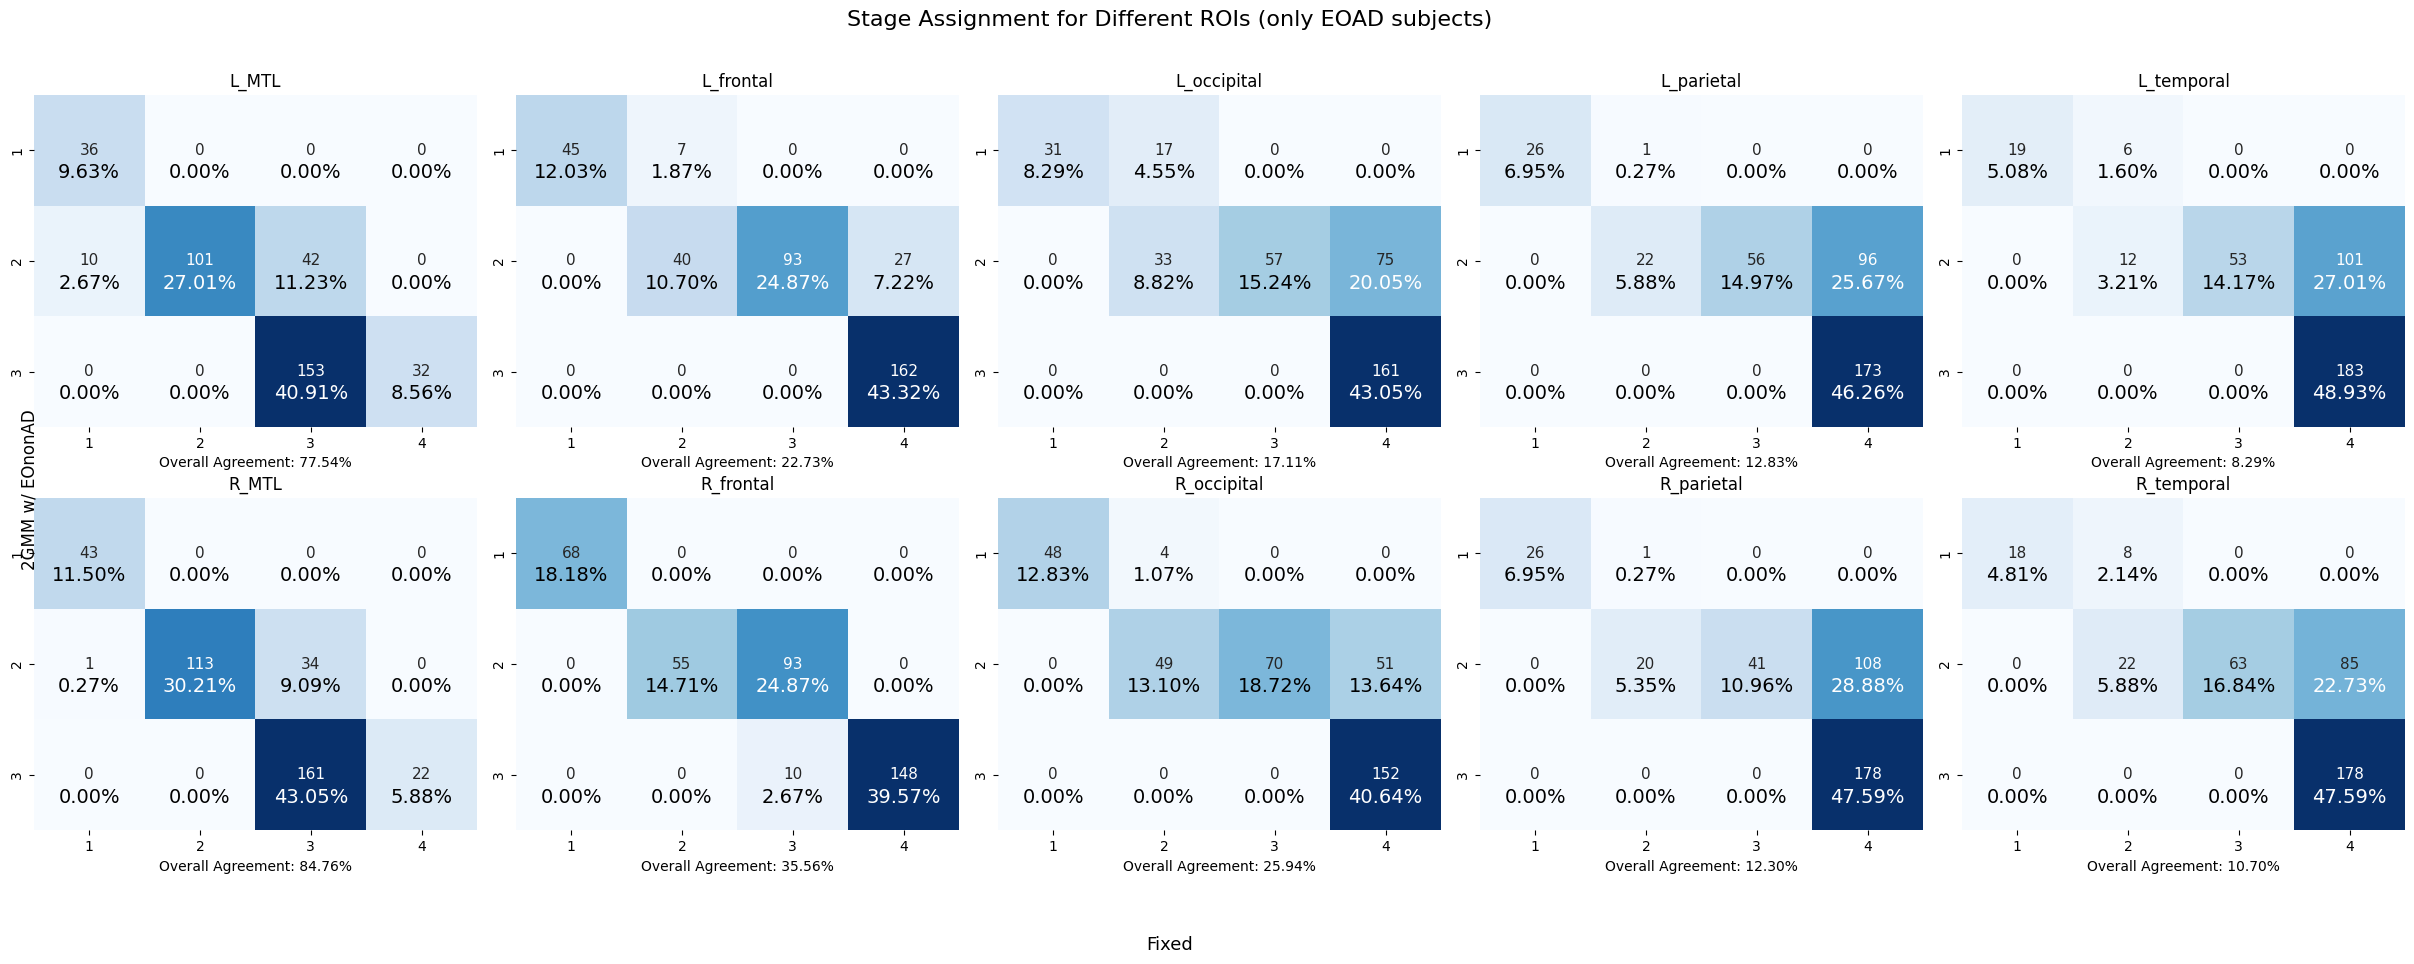

In [279]:

plot_confusion_matrices(contigency_df, rois, 'gmm2_varied','2GMM w/ EOnonAD', 'gmm2non_varied','2GMM w/o EOnonAD') # y, x

In [71]:
#to wide:
gmm2z.drop(columns=['Unnamed: 0'],inplace=True)
gmm2z_wide = gmm2z.pivot(index=['subj','dx'], columns='lobe', values='value').reset_index()[['subj','dx'] + lobes]
gmm2z_wide 

lobe,subj,dx,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal
0,LDS0070120,CN,0.732856,0.738673,0.005027,0.311309,-0.258979,-0.444753,0.108475,0.098508,0.105870,0.283103
1,LDS0070166,EOAD,7.543417,5.730201,27.955709,25.892019,20.186223,16.710129,36.391121,27.582178,29.197759,30.108455
2,LDS0070174,EOAD,1.883974,1.271264,18.740653,18.814639,9.942651,9.245584,19.465008,12.923950,20.963875,20.895289
3,LDS0070176,CN,-0.630208,-0.827316,-0.713735,-0.499379,-0.198924,-0.206714,-0.307235,-0.433037,0.207811,0.458061
4,LDS0070199,EOAD,3.999644,3.020953,11.823428,11.122044,7.725908,7.742617,10.353135,9.943339,12.668151,13.190164
...,...,...,...,...,...,...,...,...,...,...,...,...
576,LDS9410574,EOAD,3.854807,4.203316,23.888052,26.320307,8.840280,13.106291,21.769659,30.641138,15.925076,21.888055
577,LDS9410608,EOAD,8.702054,5.877296,19.048985,16.327730,4.111023,2.222904,23.075520,11.070858,13.343846,11.421694
578,LDS9410622,EOAD,4.084192,5.206212,1.067956,3.060161,-0.717395,-0.600731,-3.322282,-2.788662,-2.203711,-2.042158
579,LDS9410638,EOnonAD,0.937754,0.340946,0.534675,1.212270,0.596911,0.698344,0.000371,0.129343,0.114607,0.344579


# some visualizations (redundant)

### boxplots 

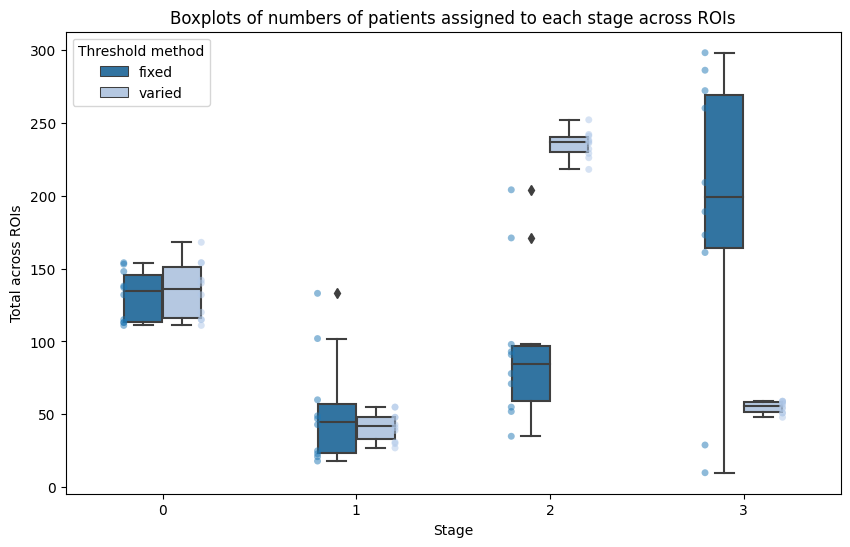

In [191]:
# Plot side-by-side boxplots
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_palette('tab20')
#plot
sns.boxplot(x='stage', y='total', hue='method', data=stagect, width=0.4, ax=ax)

sns.stripplot(x='stage', y='total', hue='method', data=stagect, dodge=True, jitter=False, alpha=0.5, ax=ax)
plt.xlabel('Stage')
plt.ylabel('Total across ROIs')
plt.title('Boxplots of numbers of patients assigned to each stage across ROIs')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[0:2], labels[0:2], title='Threshold method')
plt.show()


In [192]:
# this is just to see what're the outliers 
import plotly.express as px

# Create a boxplot with Plotly
fig = px.box(stagect, x='stage', y='total', color='method', title='Boxplots of numbers of patients assigned to each stage across ROIs',
             labels={'stage': 'Stage', 'total': 'Total across ROIs'},
             hover_data=['roi'],
              
               width=800, height=500)

# Add stripplot data
for trace in fig.data:
    trace.update(marker=dict(size=5, opacity=0.5), line=dict(width=0))

# Update legend
fig.update_traces(showlegend=True, boxmean=True)

# Show the plot
fig.show() 

### clustered barcharts

some similar visulizations ?

Amyloid-β (A)/tau (T) profiles measured using CSF and imaging biomarkers across diagnostic groups.
https://www.nature.com/articles/s41380-021-01263-2/figures/1

Concordance and discordance between amyloid-β, tau, and neurodegeneration (ATN) biomarkers. 
https://www.nature.com/articles/s41380-021-01263-2/figures/3

<Figure size 1200x600 with 0 Axes>

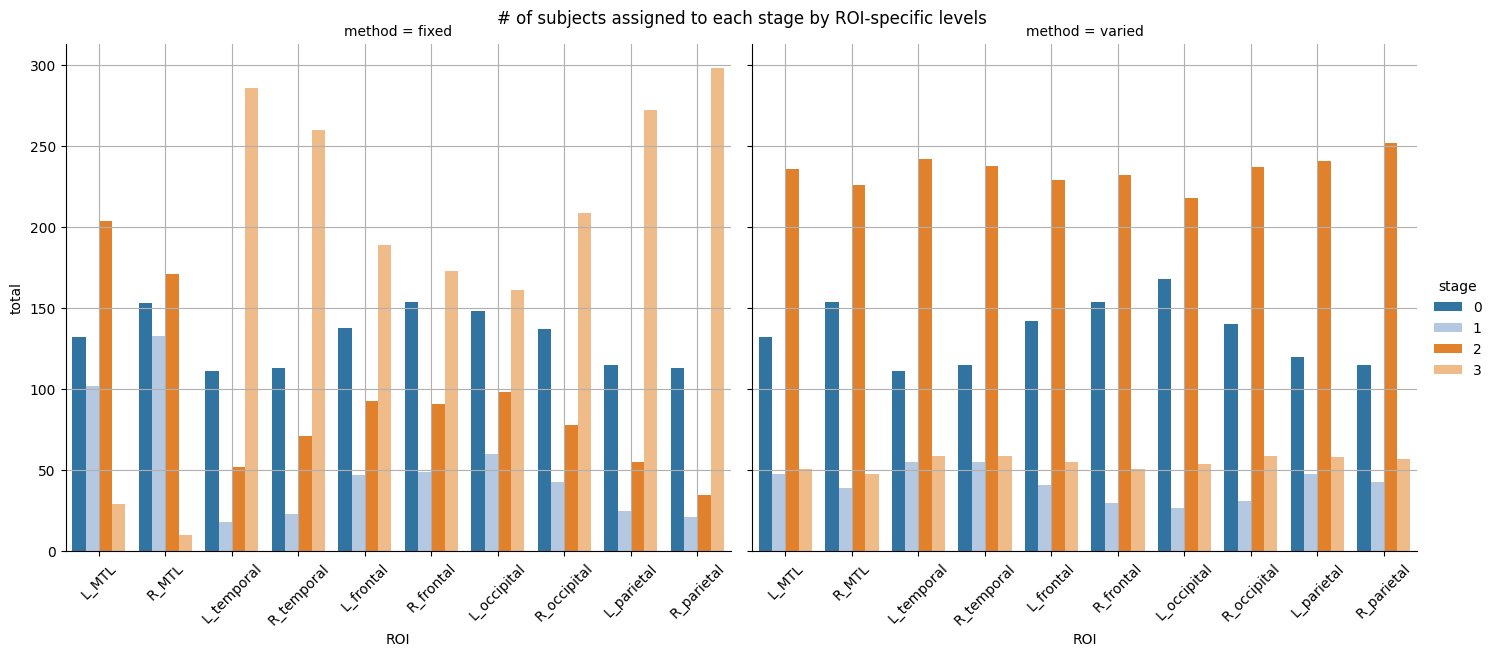

In [193]:
plt.figure(figsize=(12,6))
g = sns.catplot(data=stagect, kind='bar', y='total', hue='stage', x='roi', col='method', height=6, aspect=1.2)
 
#style
for ax in g.axes.flat:
    ax.grid(True)
    ax.set_xlabel('ROI')  
    ax.tick_params(axis='x', labelrotation=45)   
plt.suptitle('# of subjects assigned to each stage by ROI-specific levels',y=1)
plt.ylabel('Total')
plt.show()


### alt. stacked categorical bar 

modified from
https://stackoverflow.com/questions/64084755/how-do-i-plot-stacked-barplots-side-by-side-in-python-preferentially-seaborn

In [194]:
from matplotlib.patches import Patch
def stack_catplot(x, y, cat, stack, data, palette=sns.color_palette('tab20'),xorder=lobes):
    #reindex palette
    palette = [sns.color_palette('tab20')[i] for i in [0,2,4,6,1,3,5,7]]
    ax = plt.gca()
    # pivot the data based on categories and stacks
    sdf = data.pivot_table(values=y, index=[cat, x], columns=stack, 
                          dropna=False, aggfunc='sum').fillna(0)
    ncat = data[cat].nunique()
    nx = data[x].nunique()
    nstack = data[stack].nunique()
    range_x = np.arange(nx)
    width = 0.8 / ncat # width of each bar

    #sort it so l and r are together, or some other x order 
    data[x] = pd.Categorical(data[x], categories=xorder, ordered=True)
    data = data.sort_values(by=x)

    for i, c in enumerate(data[cat].unique()): #cat is the cluster
        # iterate over categories, i.e., Conditions
        # calculate the location of each bar
        loc_x = (0.5 + i - ncat / 2) * width + range_x
        bottom = 0
        for j, s in enumerate(data[stack].unique()): #stack goes into the same bar
            # iterate over stacks, i.e., Hosts
            # obtain the height of each stack of a bar
            height = sdf.loc[c][s].values
            # plot the bar, you can customize the color yourself
            ax.bar(x=loc_x, height=height, bottom=bottom, width=width, 
                   color=palette[j + i * nstack], zorder=10)
            # change the bottom attribute to achieve a stacked barplot
            bottom += height
    # make xlabel
    ax.set_xticks(range_x)
    ax.set_xticklabels(data[x].unique(), rotation=45)
    ax.set_ylabel(y)
    # make legend
    plt.legend([Patch(facecolor=palette[i]) for i in range(ncat * nstack)], 
               [f"{c}: {s}" for c in data[cat].unique() for s in data[stack].unique()],
               bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid()
    plt.show()
    


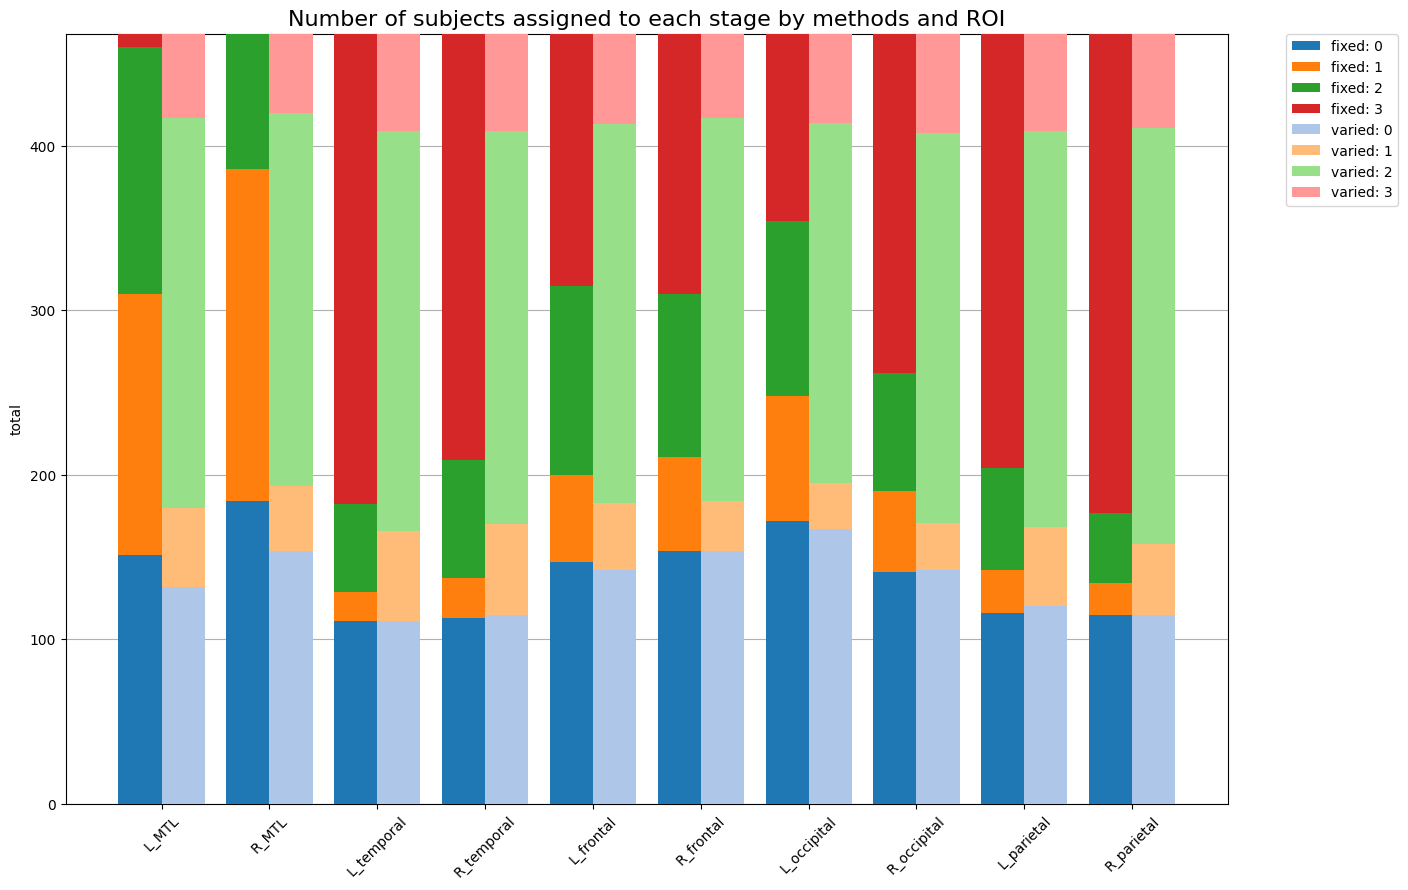

In [126]:
plt.figure(figsize=(15,10))
plt.title('Number of subjects assigned to each stage by methods and ROI',fontsize=16)
stack_catplot(x='roi', y='total', cat='method', stack='stage', data=stagect)

## heatmaps

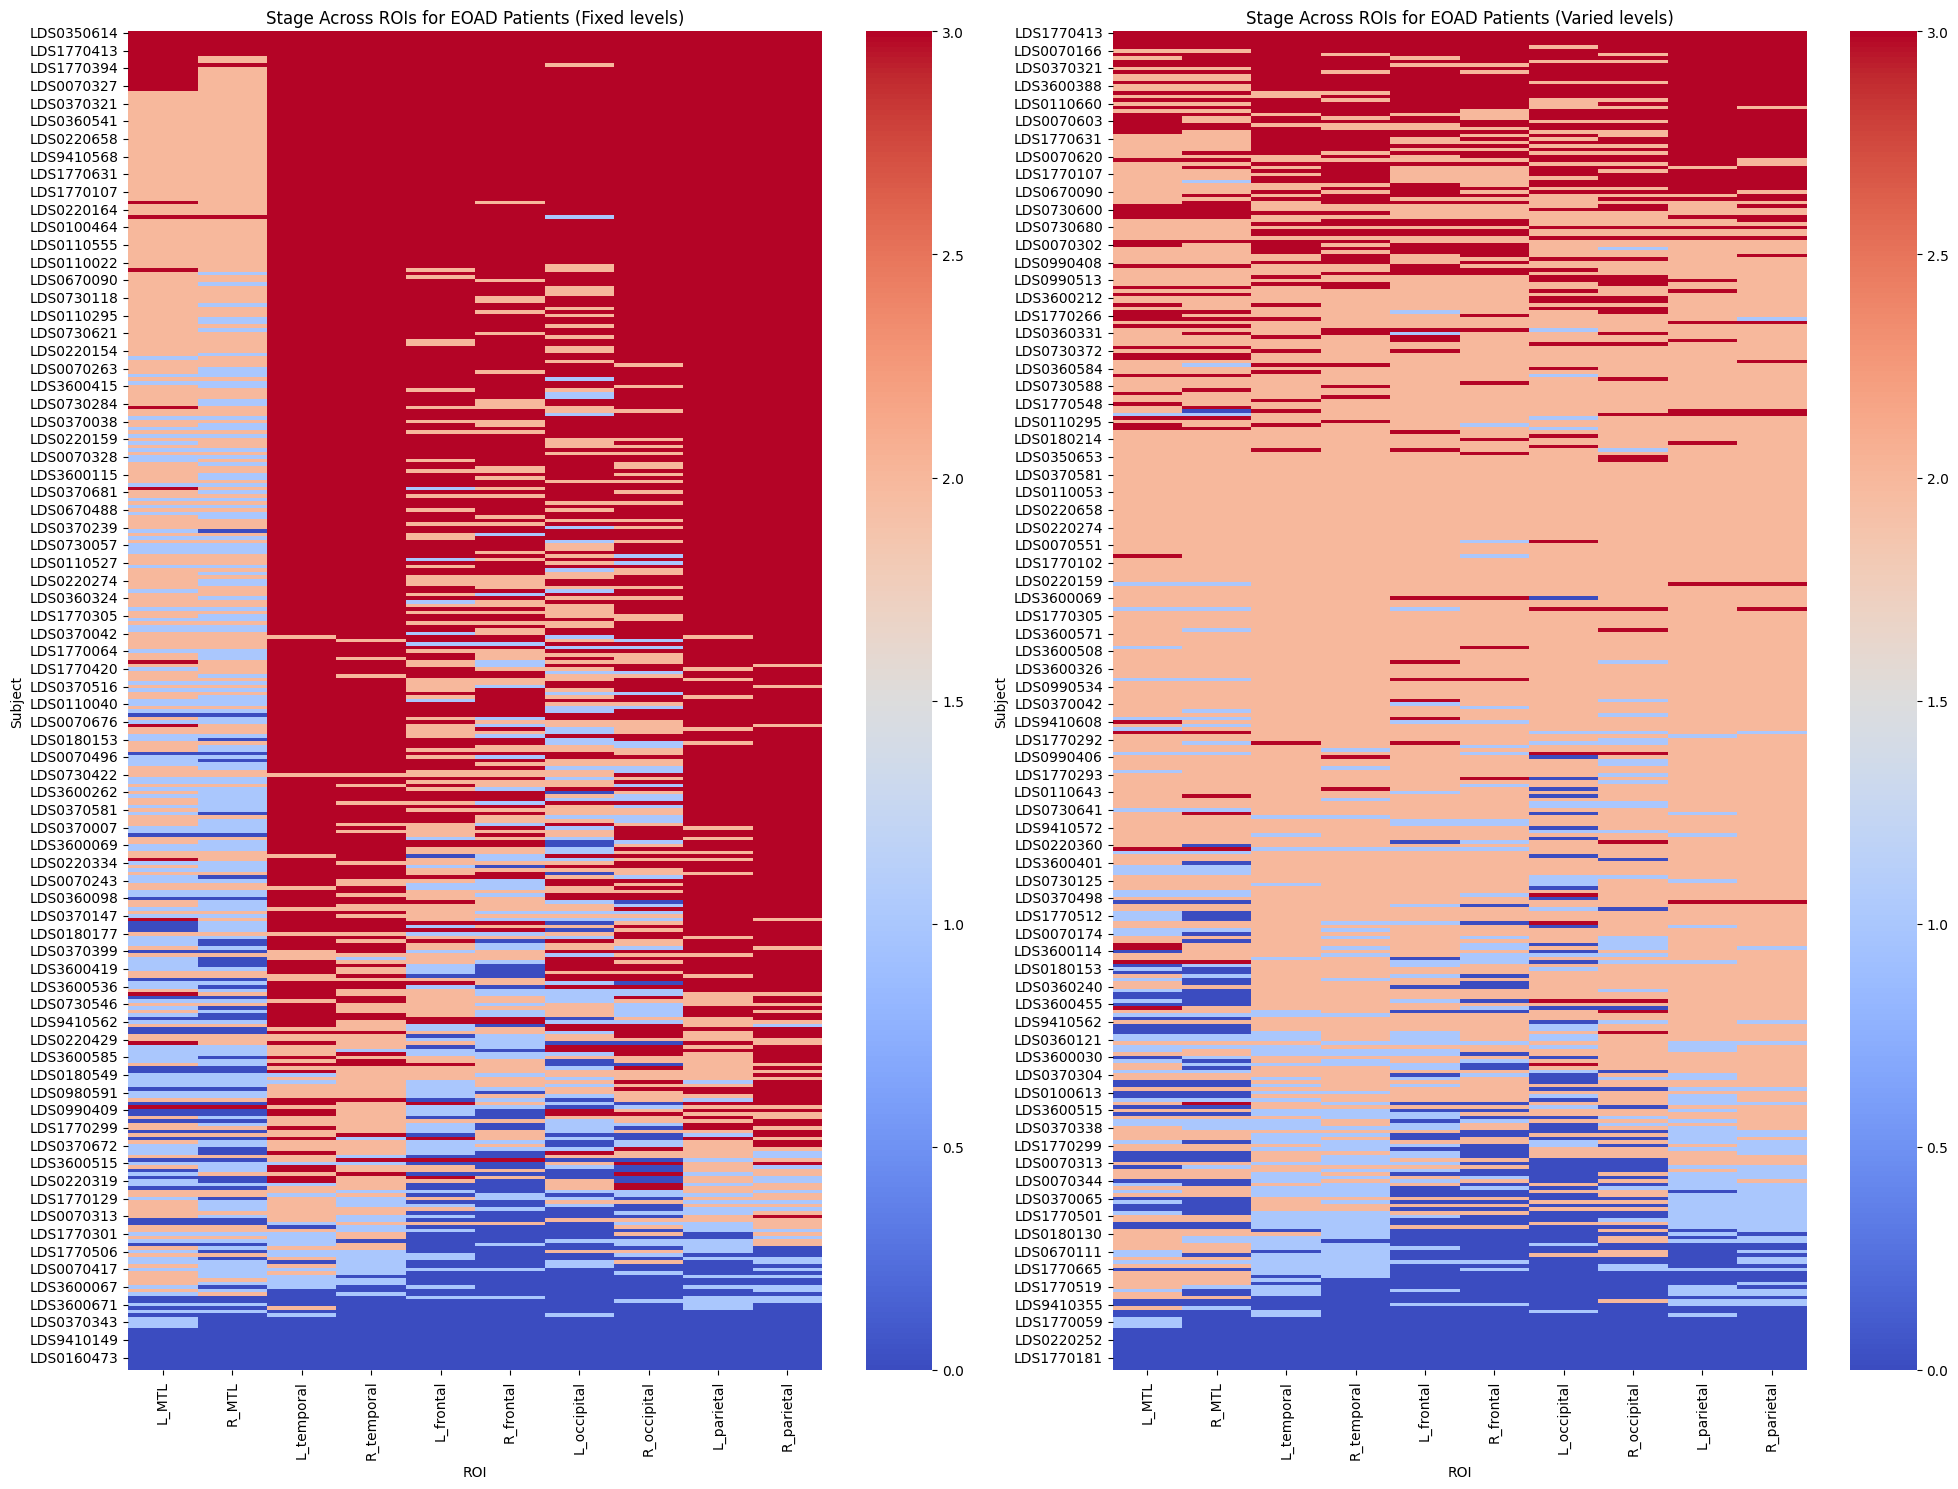

In [195]:

cuts_data = {
    "Fixed": fixed_cut[fixed_cut['dx'] == 'EOAD'],
    "Varied": varied_cut[varied_cut['dx'] == 'EOAD']
}

# side-by-side heatmaps
fig, axs = plt.subplots(1, 2, figsize=(20,15))

for i, (title, data) in enumerate(cuts_data.items()):
    # sort
    avg_stage = data.groupby('subj')['stage'].mean().sort_values(ascending=False).index
    pivot_table = data.pivot(index='subj', columns='roi', values='stage')[lobes] #left-right order
    sns.heatmap(data=pivot_table.loc[avg_stage], cmap='coolwarm', ax=axs[i])
    
    axs[i].set_title(f'Stage Across ROIs for EOAD Patients ({title} levels)')
    axs[i].set_xlabel('ROI')
    axs[i].set_ylabel('Subject')

plt.tight_layout()
plt.show()


# Ignore below


https://www.nature.com/articles/s43587-024-00573-8/figures/1  #ehr, prediction heatmap

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8985353/  #thresholding overview for tau+ on mean suvr

https://alzres.biomedcentral.com/articles/10.1186/s13195-016-0233-7 #component fit, csf

https://www.neurology.org/doi/10.1212/WNL.0000000000200735 #data drien thresholding ab compare (same methods, diffeent cohorts)

+sns.heatmap, row = ROI sort by mean z-scores across all subjects within each ROI to order; column = subject (EOAD/EOAD+CN)

In [240]:
dnf = pd.read_csv('/Users/linlin/Desktop/to be processed/aka spare/f2dnf.csv',names = ['Classification','No.','Driver','Team','Reason'])

In [241]:
dnf['Reason'].replace({'engine':'Engine'},inplace=True)
dnf['Reason'].unique()

array(['Collision', 'Loose wheel', 'Spin', 'Suspension', 'Accident',
       'Retired', 'Disqualified', 'Driveshaft', 'Hyradulics',
       'Power loss', 'Stalled', 'Engine', 'Transmission', 'Withdrew',
       'Brakes'], dtype=object)

In [242]:
classification_mapping = {
    'Collision': 'Accident/Incident',
    'Loose wheel': 'Mechanical Failure',
    'Spin': 'Spun',
    'Suspension': 'Mechanical Failure',
    'Accident': 'Accident/Incident',
    'Retired': 'Retired/Withdrew',
    'Disqualified': 'Disqualified',
    'Driveshaft': 'Mechanical Failure',
    'Hydraulics': 'Mechanical Failure',
    'Power loss': 'Mechanical Failure',
    'Stalled': 'Mechanical Failure',
    'Engine': 'Mechanical Failure',
    'Transmission': 'Mechanical Failure',
    'Withdrew': 'Retired/Withdrew',
    'Brakes': 'Mechanical Failure'
}

# Apply classification mapping
dnf['General'] = dnf['Reason'].map(classification_mapping)


In [247]:
# Group by 'Driver' and 'General Category', then count occurrences
grouped_df = dnf.groupby(['Driver', 'General'])['No.'].agg(len).reset_index(name='Count')
grouped_df[grouped_df['General'] == 'Mechanical Failure'].sort_values(by='Count', ascending=False)


,Driver,General,Count
1,Amaury Cordeel,Mechanical Failure,2
24,Oliver Bearman,Mechanical Failure,2
27,Paul Aron,Mechanical Failure,2
29,Pepe Martí,Mechanical Failure,2
41,Taylor Barnard,Mechanical Failure,2
9,Franco Colapinto,Mechanical Failure,1
12,Gabriel Bortoleto,Mechanical Failure,1
14,Isack Hadjar,Mechanical Failure,1
17,Jak Crawford,Mechanical Failure,1
19,Joshua Dürksen,Mechanical Failure,1
